# Image classification in the MNIST dataset using fully supervised CNN

In [2]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import History, ModelCheckpoint
from tensorflow.keras import initializers
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import struct
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

## Data preprocessing

In [45]:
def open_mnist(path):
    
    enc = OneHotEncoder()
    
    # train images
    with open(path + '/train-images-idx3-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        X_train = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        X_train = X_train.reshape((size, nrows, ncols, 1))
        print('Images train set shape:', X_train.shape)
    
    # test images
    with open(path + '/t10k-images-idx3-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        X_test = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        X_test = X_test.reshape((size, nrows, ncols, 1))
        print('Images test set shape:', X_test.shape)
        
    # train labels
    with open(path + '/train-labels-idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        y_train = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        y_train = y_train.reshape((size, 1))
        y_train = enc.fit_transform(y_train).toarray()
        print('Train labels shape:', y_train.shape)

    # test labels
    with open(path + '/t10k-labels-idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        y_test = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        y_test = y_test.reshape((size, 1))
        y_test = enc.fit_transform(y_test).toarray()
        print('Test labels shape:', y_test.shape)
        
    return X_train, X_test, y_train, y_test

path = 'data/MNIST'
X_train, X_test, y_train, y_test = open_mnist(path)

Images train set shape: (60000, 28, 28, 1)
Images test set shape: (10000, 28, 28, 1)
Train labels shape: (60000, 10)
Test labels shape: (10000, 10)


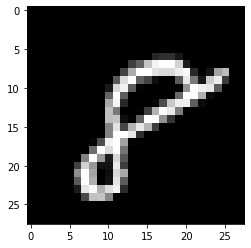

In [46]:
plt.imshow(X_train[-1,:,:,0], cmap='gray')
plt.show()

## Train model

In [3]:
def get_classifier(input_shape, n_classes):
    
    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    
    model = Sequential()
    
    """
    ********** Feature extraction layers ********** 
    """
    
    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(2,2),strides=(2,2), padding='valid'))  #None, None
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())
    
    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(2,2), strides=(1,1), padding='valid')) #kernel_size=(5,5) dans le papier
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())
    
    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())
    
    """
    ********** Classification layers **********
    """
    # Passing it to a dense layer
    model.add(Flatten())
    # 1st Dense Layer
    model.add(Dense(124))
    model.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())
    
    # 2nd Dense Layer
    model.add(Dense(62))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())
    
    # Output Layer
    model.add(Dense(n_classes))  
    model.add(Activation('softmax'))
    
    model.summary()
    
    # (4) Compile
    #adam=Adam(lr=0.00001, decay=0.001)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [26]:
cnn = get_classifier((X_train.shape[1],X_train.shape[2],1),n_classes = 10)

------------------------------
Creating and compiling model...
------------------------------
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 14, 14, 96)        480       
_________________________________________________________________
activation_18 (Activation)   (None, 14, 14, 96)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 96)          0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 7, 7, 96)          384       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 256)         98560     
_________________________________________________________________
activation_19 (Activation)   (None, 6, 6, 256)         0         
__________________________

In [27]:
history = cnn.fit(X_train,y_train, batch_size = 2000, epochs = 200)

Train on 60000 samples
Epoch 1/200
60000/60000 [==============================] - 4s 74us/sample - loss: 0.7952 - accuracy: 0.7868
Epoch 2/200
60000/60000 [==============================] - 3s 54us/sample - loss: 0.2669 - accuracy: 0.9481
Epoch 3/200
60000/60000 [==============================] - 3s 54us/sample - loss: 0.1612 - accuracy: 0.9697
Epoch 4/200
60000/60000 [==============================] - 3s 54us/sample - loss: 0.1153 - accuracy: 0.9786
Epoch 5/200
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0888 - accuracy: 0.9833
Epoch 6/200
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0679 - accuracy: 0.9882
Epoch 7/200
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0548 - accuracy: 0.9904
Epoch 8/200
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0445 - accuracy: 0.9919
Epoch 9/200
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0359 - accuracy: 0.9937
Epoch

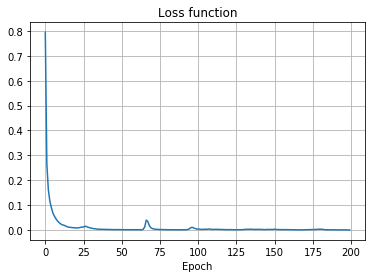

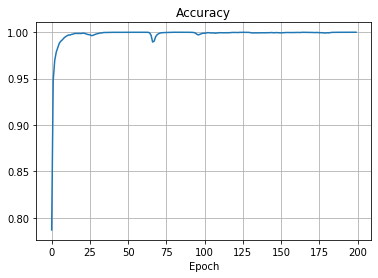

In [30]:
plt.plot(history.history['loss'])
plt.title('Loss function')
plt.xlabel('Epoch')
plt.grid()
plt.show()

plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.grid()
plt.xlabel('Epoch')
plt.show()

In [32]:
cnn.save_weights('models/cnn_sup')

## Load model

In [4]:
cnn_loadded = get_classifier((X_train.shape[1],X_train.shape[2],1),n_classes = 10)

NameError: name 'X_train' is not defined

In [49]:
cnn_loadded.load_weights('models/cnn_sup')

In [50]:
score = cnn_loadded.evaluate(X_test, y_test, verbose = 0)

In [51]:
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.08971962127429858
Test accuracy:  0.9892


In [73]:
def plot_confusion_matrix(model, x, y_true, title = ''):
    """
    :param model: instance of the model
    :param x: input data
    :param y_true: true labels
    :param title: image title
    :return:
    """
    
    y_pred = model.predict_classes(x.astype('float16'))
    cm = tf.math.confusion_matrix(labels=np.argmax(y_true,axis=1), predictions=y_pred).eval(session = tf.Session())

    # we normalize the confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize = (6,6))

    # we plot

    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    fmt = '.2f'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.title(title)
    plt.show()

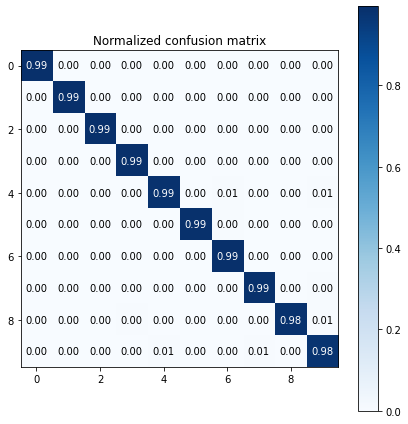

In [74]:
plot_confusion_matrix(cnn_loadded, X_test, y_test, title = 'Normalized confusion matrix')